# **Proyecto Final de Curso: Diplomado en Ciencias de Datos - UPTC**
En este es un proyecto de clasificación para ayudar a una compañía financiera a clasificar el puntaje crediticio de sus consumidores en función de la información relacionada con el crédito de los consumidores. La empresa ha estado realizando esta tarea de clasificación manualmente a lo largo de los años y ahora ha decidido construir un sistema inteligente que pueda hacerlo automáticamente utilizando los datos recopilados hasta este momento. La dirección de la empresa le pidió a: *Arvy Nathaniel*, un científico de datos, que ayudara a construir los modelos de clasificación. - Tomado de: *"https://www.kaggle.com/code/arvynathaniel/credit-score-classification-cleaning-ml/notebook"*

Durante este proyecto, harémos uso de las herramientas de análisis exploratorio de datos vistas en clase y desarrollaremos un proyecto de EDA desde cero con base a un dataset de ejemplo en el cuál responderémos diferentes preguntas a cerca de nuestro conjunto de datos con base a las cinco fases básicas del proceso de EDA:

*   Importación de datos y dependencias
*   Detección de valores nulos y duplicados
*   Análisis univariado de variables numéricas
*   Análisis de variables categóricas
*   Análisis bivariado y de correlación
*   Análisis multivariado






# **1.Importación de datos y dependencias**

### 1.1. Dependencias

In [1]:
# Propósito general-- Probamos estas de la clase 3
import warnings
import re
warnings.simplefilter(action='ignore')
# Manejo de datos
import numpy as np
import pandas as pd
from io import StringIO

# Visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# EDA
import missingno
import statsmodels.api as sm
from sklearn.impute import KNNImputer
import scipy.stats as sts
from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTE
# Pipelines y preprocesamiento
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

### 1.2 Utilidades

**Toolkit de python para transformación de Data**

In [2]:

def convertir_a_entero(columna):
    """
    Convierte una columna de tipo objeto a entero, eliminando los caracteres no numéricos.
    
    Argumentos:
    columna (pandas.Series): Columna de tipo objeto que se desea convertir a entero.
    
    Retorna:
    pandas.Series: Columna convertida a entero.
    """
    
    # Expresión regular para eliminar caracteres no numéricos y guiones negativos
    patron = r'[^0-9-]'
    
    # Eliminar los caracteres no numéricos y guiones negativos
    columna_limpia = columna.apply(lambda x: re.sub(patron, '', str(x)))
    
    # Convertir la columna limpia a entero
    columna_entero = pd.to_numeric(columna_limpia, errors='coerce')
    
    # Reemplazar los valores vacíos por NaN
    columna_entero = columna_entero.fillna(pd.NA)
    
    return columna_entero

In [3]:
def convertir_a_flotante(df, column_name):
    """
    Convierte una columna de tipo object a float en un DataFrame de Pandas.
    Si hay valores no numéricos (como "_", " ", "-"), los convierte a NaN.
    
    Parámetros:
    df (pandas.DataFrame): DataFrame que contiene la columna a convertir.
    column_name (str): Nombre de la columna a convertir.
    
    Retorna:
    pandas.Series: La columna convertida a tipo float.
    """
    # Reemplazar los caracteres especiales por NaN
    df[column_name] = df[column_name].replace(['_', ' ', '-'], np.nan, regex=True)
    
    # Convertir la columna a float
    try:
        column_float = df[column_name].astype(float)
    except ValueError:
        # Si hay valores que no se pueden convertir a float, los convierte a NaN
        column_float = pd.to_numeric(df[column_name], errors='coerce')
    
    return column_float

In [4]:
def limpiar_columnas(df, columnas):
    """
    Limpia las columnas de tipo 'object' en un DataFrame, eliminando caracteres no numéricos
    y convirtiendo los valores no numéricos a NaN.

    Argumentos:
    df (pandas.DataFrame): DataFrame que contiene las columnas a limpiar.
    columnas (list): Lista de nombres de columnas a limpiar.

    Retorna:
    pandas.DataFrame: DataFrame con las columnas especificadas limpiadas.
    """
    limpiar_columna = lambda col: col.apply(lambda x: pd.to_numeric(re.sub(r'[^0-9.-]', '', str(x)), errors='coerce'))

    for col in columnas:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = limpiar_columna(df[col])

    return df

In [5]:
#--------------------------------------------------------------------------------
#--------------------------------- Histogram-Box --------------------------------
#--------------------------------------------------------------------------------

def histogram_box(dataframe, variable):
  df = dataframe
  fig, ax = plt.subplots(1,2,figsize=(14,5))
  # histogram_box plot
  sns.histplot(data=df, x=str(variable), kde=True, ax=ax[0])
  sns.boxplot(data=df, x=str(variable))
  # mean
  mean = df[str(variable)].mean()
  ax[0].axvline(mean, color='red')
  # stats-box
  variance = round(df[str(variable)].var(),2)
  kurtosis = round(df[str(variable)].kurt(),2)
  skewness = round(df[str(variable)].skew(),2)

  textstr = '\n'.join( (r'mean=%.2f' % (mean, ), r'Variance=%.2f' % (variance, ), r'Kurtosis=%.2f' % (kurtosis, ), r'Skewness=%.2f' % (skewness, )) )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
  ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
  ax[0].set_title(f'Histogram of {variable}')
  ax[0].set_xlabel(f'{variable}')
  ax[0].set_ylabel("Frecuency")
  ax[0].grid(True)
  ax[1].set_title(f'Boxplot of {variable}')
  ax[1].set_xlabel(f'{variable}')
  ax[1].set_ylabel("Frecuencias")
  ax[1].grid(True)

  plt.subplots_adjust(hspace=0.5)
  plt.show()

In [6]:
# Seleccionar la variable de interés
def histogram_box_new(dataframe, columna):
        #variable = data_credit['Monthly_Balance']
        variable = dataframe[columna]

        # Configurar la figura y los subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Crear el histograma
        ax1.hist(variable, bins=20, edgecolor='black')
        ax1.set_title('Histograma')
        ax1.set_xlabel(columna)
        ax1.set_ylabel('Frecuencia')

        # Crear el gráfico de densidad
        variable.plot.density(ax=ax2)
        ax2.set_title('Densidad')
        ax2.set_xlabel(columna)
        ax2.set_ylabel('Densidad')

        # Ajustar el espaciado entre subplots
        plt.subplots_adjust(wspace=0.4)

        # Mostrar la figura completa
        plt.show()

### 1.3 Importación y Descripción General de los datos

El conjunto de Datos objeto de análisis contiene 100.000 Filas (Registros) y 28 Columnas (Variables).
Con este conjunto recopilado de forma manual se pretende ser la base para predecir el puntaje crediticio de cada cliente.
De forma General tenemos:


 El diccionario de los datos es el siguiente:

|Variable|Descripción|Tipología|
|---|---|---|
|ID| Representa un único valor por entrada de registro|Numérica|
|Customer_ID|Ientificación de una (única) persona|Numérica|
|Month|Representa el mes del Año|Categórica|
|Name|Nombre de la persona|Categórica|
|Age|La edad de la persona|numérico|
|SSN|Número de Identificación de Seguridad|Numérica|
|Occupation|Representa la ocupación de la persona|Categórica|
|Annual_Income|Ingreso Anual de la persona|Numérica|
|Monthly_Inhand_Salary|Salario base mensual de la persona|Numérica|
|Num_Bank_Accounts|Representa el Número de Cuentas bancarias de la persona|Numérica|
|Num_Credit_Card|Representa la cantidad de otras tarjetas de crédito que tiene la persona|Numérica|
|Interest_Rate|Representa la tasa de interés de la tarjeta de crédito|Numérica|
|Num_of_Loan|Representa el número de préstamos tomados del banco por la persona|Numérica|
|Type_of_Loan|Representa el tipo de crédito que tiene la persona|Categórica|
|Delay_from_due_date|Representa el promedio numérico de dias de atraso desde la fecha de pago|Numérica|
|Num_of_Delayed_Payment|Reprenta el promedio numérico de pagos atrasados de la persona|Numérica|
|Changed_Credit_Limit|Representa el porcentaje de cambio en el límite de la tarjeta de crédito|Numérica|
|Num_Credit_Inquiries|Reprenta el número de consultas de tarjetas de crédito|Numérica|
|Credit_Mix|Reprenta la clasificación de la mezcla de créditos|Categórica|
|Outstanding_Debt|Representa el faltante de la deuda por pagar (saldo en USD)|Numérica|
|Credit_Utilization_Ratio|Reprenta el radio de utilización del creédito|Numérica|
|Credit_History_Age|Reprenta la edad de la vida crediticia de la persona|Numérica|
|Payment_of_Min_Amount|Reprenta si la persona sólo pago la cantidad mínima|Categórica|
|Total_EMI_per_month|Reprenta el total de pagos EMI (cuotas mensuales equivalentes)|Numérica|
|Amount_invested_monthly|Reprenta las inversiones mensuales de las personas (Seguros, ahorro, etc.)|Numérica|
|Payment_Behaviour|Reprenta el comportamiento de pago del cliente|Categórica|
|Monthly_Balance|Reprenta el balance mensual del cliente (En USD)|Numérica|


In [7]:
# Importación de datos
path = './train.csv'
raw_df = pd.read_csv(path,low_memory=False)

## 1.3.1 Información General del DataSet

Descripción General de los tipos de variables usados en el Conjunto de Datos, obtenemos información adicional de los valores encontrads por cada variable.

In [8]:
#información del Dataset
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

El dataset tiene varias inconsistencias que señalizarán más adelante, se corregirán las nesarias, ya que en esencia es lo que corresponde a la Etapa EDA (Análisi Exploratorio de Datos), por ejemplo: El tipo de dato para ID, debe ser Entero, no un Object.

In [9]:
#los primeros 5 datos
raw_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## 1.4 Descripción de Algunas Variables del Modelo

De forma General y con el ánimo de entender mejor el Conjunto de datos, vamos a describir algunas de sus variables.


### 1.4.1 Changed_Credit_Limit

*Changed_Credit_Limit:* es una variable que rastrea los cambios en los límites de crédito de un prestatario proporcionando información valiosa sobre cómo los acreedores perciben el riesgo del prestatario y su capacidad para manejar el crédito a lo largo del tiempo.\
Esta variable puede tomar diferentes formas dependiendo del contexto, pero generalmente se expresa como un valor numérico que representa el aumento o disminución en el límite de crédito.\

Por ejemplo:

<ol><li>Un valor positivo (ej. 1000) indicaría que el límite de crédito se incrementó en esa cantidad (ej. de $5,000   - $6,000). </li>
<li>Un valor negativo (ej. -500) indicaría que el límite de crédito se redujo en esa cantidad (ej. de $10,000   - $9,500). </li>
<li>Un valor de cero (0) indicaría que no hubo cambios en el límite de crédito durante ese período. </li>

In [10]:
print(raw_df["Changed_Credit_Limit"])
print('\n\n')
print('\n Veamos el describe(): \n\n', raw_df["Changed_Credit_Limit"].describe())

0        11.27
1        11.27
2            _
3         6.27
4        11.27
         ...  
99995     11.5
99996     11.5
99997     11.5
99998     11.5
99999     11.5
Name: Changed_Credit_Limit, Length: 100000, dtype: object




 Veamos el describe(): 

 count     100000
unique      4384
top            _
freq        2091
Name: Changed_Credit_Limit, dtype: object


### 1.4.2 Num_of_Delayed_Payment
*Num_of_Delayed_Payment:* es una variable que indica los dias de retraso que tiene un acreedor.

In [11]:
print(raw_df["Num_of_Delayed_Payment"])
print('\n\n')
print('\n Veamos el describe(): \n\n', raw_df["Num_of_Delayed_Payment"].describe())

0          7
1        NaN
2          7
3          4
4        NaN
        ... 
99995      7
99996      7
99997      6
99998    NaN
99999      6
Name: Num_of_Delayed_Payment, Length: 100000, dtype: object




 Veamos el describe(): 

 count     92998
unique      749
top          19
freq       5327
Name: Num_of_Delayed_Payment, dtype: object


### 1.4.3 Credit_Score
*Credit_Score:*  Es la variable Objetivo, Inicialmente Categórica, Se podrá Transformar en un Valor de Probabilidad, para indicar si a un Cliente puede asignar una Tarjeta de Crédito.

In [12]:
print(raw_df["Credit_Score"])
print('\n\n')
print('\n Veamos el describe(): \n\n', raw_df["Credit_Score"].describe(), '\n\n')
raw_df['Credit_Score'].unique()

0            Good
1            Good
2            Good
3            Good
4            Good
           ...   
99995        Poor
99996        Poor
99997        Poor
99998    Standard
99999        Poor
Name: Credit_Score, Length: 100000, dtype: object




 Veamos el describe(): 

 count       100000
unique           3
top       Standard
freq         53174
Name: Credit_Score, dtype: object 




array(['Good', 'Standard', 'Poor'], dtype=object)

### 1.4.4 Monthly_Balance
*'Monthly_Balance (Saldo mensual)* es una variable comúnmente utilizada en el análisis de crédito y riesgo crediticio que representa el saldo adeudado por un prestatario al final de cada mes en una cuenta de crédito específica, como una tarjeta de crédito o línea de crédito.<br><br>
****Algunas características clave de la variable Monthly_Balance:****<br>

1-Refleja el monto que el prestatario debe después de que se hayan aplicado los pagos, cargos, intereses y cualquier otra transacción ocurrida durante ese mes.<br>
2-Generalmente se presenta como un valor numérico que puede ser positivo (si hay un saldo pendiente) o cero (si no hay saldo pendiente).<br>
3-Es una variable dinámica que puede cambiar mes a mes dependiendo del comportamiento de pago y uso del crédito del prestatario.<br>
4-Los acreedores analizan los patrones de saldos mensuales para evaluar la capacidad del prestatario para administrar su deuda y realizar pagos oportunos.<br>
5-Un saldo mensual alto y persistente puede ser una señal de que el prestatario está teniendo dificultades para pagar o está utilizando demasiado crédito.<br>
6-Un saldo mensual bajo o cero puede indicar que el prestatario está manejando su deuda de manera efectiva y realizando pagos adecuados.<br>

In [13]:
print(raw_df["Monthly_Balance"]+'\n')
print('\n Imprimiendo el describe(): \n', raw_df["Monthly_Balance"].describe())

0        312.49408867943663\n
1        284.62916249607184\n
2         331.2098628537912\n
3        223.45130972736786\n
4        341.48923103222177\n
                 ...         
99995    479.86622816574095\n
99996      496.651610435322\n
99997     516.8090832742814\n
99998     319.1649785257098\n
99999     393.6736955618808\n
Name: Monthly_Balance, Length: 100000, dtype: object

 Imprimiendo el describe(): 
 count                                98800
unique                               98792
top       __-333333333333333333333333333__
freq                                     9
Name: Monthly_Balance, dtype: object


### 1.4.5 Payment_Behaviour
*Payment_Behaviour:* El Payment_Behaviour es una variable crítica para evaluar el riesgo de crédito de un prestatario, ya que proporciona información sobre su historial de cumplimiento de pagos y su capacidad para gestionar sus obligaciones financieras.

In [14]:
raw_df["Payment_Behaviour"]
print('\n\n')
print('\n Veamos el describe(): \n\n', raw_df["Payment_Behaviour"].describe(),'\n\n')
raw_df["Payment_Behaviour"].unique()





 Veamos el describe(): 

 count                             100000
unique                                 7
top       Low_spent_Small_value_payments
freq                               25513
Name: Payment_Behaviour, dtype: object 




array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'High_spent_Large_value_payments'], dtype=object)

### 1.4.6 Amount_invested_monthly
*Amount_invested_monthly (Monto Invertido Mensualmente):* es una variable que se podría encontrar en un conjunto de datos relacionado con finanzas personales, inversiones o patrones de ahorro.<br>
Esta variable representa la cantidad de dinero que un individuo o familia invierte de forma regular, generalmente en un período mensual.

In [15]:
print(raw_df["Amount_invested_monthly"])
print('\n\n')
print('\n Veamos el describe(): \n\n', raw_df["Amount_invested_monthly"].describe())

0         80.41529543900253
1        118.28022162236736
2           81.699521264648
3         199.4580743910713
4        41.420153086217326
                ...        
99995     60.97133255718485
99996     54.18595028760385
99997     24.02847744864441
99998    251.67258219721603
99999     167.1638651610451
Name: Amount_invested_monthly, Length: 100000, dtype: object




 Veamos el describe(): 

 count         95521
unique        91049
top       __10000__
freq           4305
Name: Amount_invested_monthly, dtype: object


### 1.4.7 Credit_History_Age
*Credit_History_Age:* Esta variable se mide generalmente en años o meses y refleja el período de tiempo transcurrido desde que el prestatario obtuvo su primera línea de crédito o préstamo.

In [16]:
print('\n Veamos el describe(): \n\n', raw_df["Credit_History_Age"].describe())
print('\n\n')
raw_df["Credit_History_Age"]


 Veamos el describe(): 

 count                      90970
unique                       404
top       15 Years and 11 Months
freq                         446
Name: Credit_History_Age, dtype: object





0         22 Years and 1 Months
1                           NaN
2         22 Years and 3 Months
3         22 Years and 4 Months
4         22 Years and 5 Months
                  ...          
99995     31 Years and 6 Months
99996     31 Years and 7 Months
99997     31 Years and 8 Months
99998     31 Years and 9 Months
99999    31 Years and 10 Months
Name: Credit_History_Age, Length: 100000, dtype: object

### 1.4.8 Credit_Utilization_Ratio
*Credit_Utilization_Ratio:* Credit Utilization Ratio se refiere a la proporción del crédito total disponible que un prestatario está utilizando actualmente. Se calcula de la siguiente manera:<br>

-Credit Utilization Ratio = Deuda Pendiente Total / Límite Total de Crédito Disponible <br>
#### Donde:
*Deuda Pendiente Total:* es la suma de todos los saldos pendientes en préstamos, tarjetas de crédito y otras líneas de crédito del prestatario.<br>
*Límite Total de Crédito Disponible:* es la suma de todos los límites de crédito otorgados al prestatario.

In [17]:
print(raw_df["Credit_Utilization_Ratio"])
print('\n\n')
print('\n Veamos el describe(): \n\n', raw_df["Credit_Utilization_Ratio"].describe())

0        26.822620
1        31.944960
2        28.609352
3        31.377862
4        24.797347
           ...    
99995    34.663572
99996    40.565631
99997    41.255522
99998    33.638208
99999    34.192463
Name: Credit_Utilization_Ratio, Length: 100000, dtype: float64




 Veamos el describe(): 

 count    100000.000000
mean         32.285173
std           5.116875
min          20.000000
25%          28.052567
50%          32.305784
75%          36.496663
max          50.000000
Name: Credit_Utilization_Ratio, dtype: float64


### 1.4.9 Num_Credit_Inquiries
*Num_Credit_Inquiries:* Indica las veces que le hacen consultas por Identificación a un usuario en las centrales de Riesgo (Colombia), representa la cantidad de veces que un prestatario ha solicitado crédito o ha sido objeto de una revisión de su historial crediticio por parte de acreedores potenciales.

In [18]:
print(raw_df["Num_Credit_Inquiries"])
print('\n\n')
print('\n Veamos el describe(): \n\n', raw_df["Num_Credit_Inquiries"].describe())

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
99995    3.0
99996    3.0
99997    3.0
99998    3.0
99999    3.0
Name: Num_Credit_Inquiries, Length: 100000, dtype: float64




 Veamos el describe(): 

 count    98035.000000
mean        27.754251
std        193.177339
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: Num_Credit_Inquiries, dtype: float64


# **2. Análisis Exploratorio de Datos  (EDA)**

### 2.1 Selección de las Variables más relevantes (Primera Parte)
De las 28 Variables, en consenso el equipo determina (inicialmente) 18 Variables que se tendrían incidencia en el Score para poder adquirir una tarjeta de crédito.

In [19]:
# primero hacemos una copia del Conjunto raw
# Descripción estadística inicial de los datos numéricos
# Vamos a seleccionar sólo las columnas que requerimos para hacer el análisis
# Copy the dataset
data_credit = raw_df.copy()
relevant_columns = ["ID","Age", "Occupation","Annual_Income","Num_Bank_Accounts","Num_of_Loan", "Delay_from_due_date","Num_of_Delayed_Payment",                    
                    "Changed_Credit_Limit", "Num_Credit_Inquiries", "Credit_Mix","Outstanding_Debt","Credit_Utilization_Ratio","Payment_of_Min_Amount",
                    "Total_EMI_per_month","Amount_invested_monthly","Payment_Behaviour","Monthly_Balance","Credit_Score"]
data_credit = data_credit[relevant_columns]
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_of_Loan               100000 non-null  object 
 6   Delay_from_due_date       100000 non-null  int64  
 7   Num_of_Delayed_Payment    92998 non-null   object 
 8   Changed_Credit_Limit      100000 non-null  object 
 9   Num_Credit_Inquiries      98035 non-null   float64
 10  Credit_Mix                100000 non-null  object 
 11  Outstanding_Debt          100000 non-null  object 
 12  Credit_Utilization_Ratio  100000 non-null  float64
 13  Payment_of_Min_Amount     100000 non-null  ob

### 2.1.1 Ajuste de los tipos de Datos del Dataset.
#### Tenemos un total de 100.000 Registros
Antes de Hacer cualquier Visualización, Análisis de Outliers, o Imputación se requiere tener ajustado el Dataset con los tipos de Datos adecuados.
Se había probado Inicialmente hacer la conversión de forma directa con *df[columna] = df[columna].astype(tipo)*. <br>Sin embargo Nuestro Dataset contiene caracteres diferentes a números en algunos registros y por tal razón, este tipo de conversión genera error.

#### 2.1.2 Las variables con datos nulos y sus respectivas cantidades son:
<ol>
    <li>Num_of_Delayed_Payment, con 7002 Registros Faltantes </li>
    <li>Num_Credit_Inquiries, con 1935 Registros Faltantes </li>
    <li>Amount_invested_monthly, con 4479 Registros Faltantes </li>
    <li>Monthly_Balance , con 1200 Registros Faltantes </li>
</ol>


### 2.1.2.1  Revisión Inicial de los Valores Nulos

In [20]:
# Podemos examinar tanto valores null(nulos), como valores nan (not a numeric)
tot = len(data_credit)
nulos = (data_credit.isnull().sum())
nulidad_null = pd.DataFrame( {'Variable':nulos.index, 'Cantidad Valores Nulo': nulos.values, 'Porcentaje de Nulidad (%) ' :np.round( ((nulos.values/tot)*100),2) } )
nulidad_null

,Variable,Cantidad Valores Nulo,Porcentaje de Nulidad (%)
0,ID,0,0.00
1,Age,0,0.00
2,Occupation,0,0.00
3,Annual_Income,0,0.00
4,Num_Bank_Accounts,0,0.00
5,Num_of_Loan,0,0.00
6,Delay_from_due_date,0,0.00
7,Num_of_Delayed_Payment,7002,7.00
8,Changed_Credit_Limit,0,0.00
9,Num_Credit_Inquiries,1965,1.96


In [21]:
data_credit

,ID,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,23,Scientist,19114.12,3,4,3,7,11.27,4.0,_,809.98,26.822620,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,23,Scientist,19114.12,3,4,-1,NaN,11.27,4.0,Good,809.98,31.944960,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,-500,Scientist,19114.12,3,4,3,7,_,4.0,Good,809.98,28.609352,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,23,Scientist,19114.12,3,4,5,4,6.27,4.0,Good,809.98,31.377862,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,23,Scientist,19114.12,3,4,6,NaN,11.27,4.0,Good,809.98,24.797347,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,25,Mechanic,39628.99,4,2,23,7,11.5,3.0,_,502.38,34.663572,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.86622816574095,Poor
99996,0x25fea,25,Mechanic,39628.99,4,2,18,7,11.5,3.0,_,502.38,40.565631,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.651610435322,Poor
99997,0x25feb,25,Mechanic,39628.99,4,2,27,6,11.5,3.0,Good,502.38,41.255522,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.8090832742814,Poor
99998,0x25fec,25,Mechanic,39628.99,4,2,20,NaN,11.5,3.0,Good,502.38,33.638208,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.1649785257098,Standard


### Observación Importante:
Podemos Observar a primera vista tenemos sólo *4 Variables* Con valores Nulos, lo anterior no Corresponde del todo a la realidad del Dataset, puesto que aunque haya Valores con los registros completos, muchos de estos valores contienen cadenas de caracteres que no son del tipo de dato Correspondiente, teniendo en cuenta que son del tipo Numérico (flota / int) y dentro de los registros tenemos caracteres como: '-', '_',' '.

Vamos a 'Limpiar las columnas de tipo Object que en realidad son numéricas y que tienen Caracteres no numéricos (Ya Observados en el Archivo Raw), para tal fin tenemos una función creada en el apartado de Uilidades: *'limpiar_columnas'*

In [22]:
columnas_a_limpiar = ['Annual_Income', 'Delay_from_due_date', 'Num_of_Delayed_Payment','Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt','Amount_invested_monthly','Monthly_Balance']
data_credit = limpiar_columnas(data_credit, columnas_a_limpiar)

### 2.1.2.1  Segunda Revisión de los Valores Nulos
Una Vez aplicadas las funciones de limpieza y conversión, volvemos a re visar la cantidad de valores nulos con los que contamos en el Dataset

In [23]:
# Podemos examinar tanto valores null(nulos), como valores nan (not a numeric)
tot = len(data_credit)
nulos = (data_credit.isnull().sum())
nulidad_null = pd.DataFrame( {'Variable':nulos.index, 'Cantidad Valores Nulo': nulos.values, 'Porcentaje de Nulidad (%) ' :np.round( ((nulos.values/tot)*100),2) } )
nulidad_null

,Variable,Cantidad Valores Nulo,Porcentaje de Nulidad (%)
0,ID,0,0.00
1,Age,0,0.00
2,Occupation,0,0.00
3,Annual_Income,0,0.00
4,Num_Bank_Accounts,0,0.00
5,Num_of_Loan,0,0.00
6,Delay_from_due_date,0,0.00
7,Num_of_Delayed_Payment,7002,7.00
8,Changed_Credit_Limit,2091,2.09
9,Num_Credit_Inquiries,1965,1.96


### Observamos:
##### como ejemplo que: el Guión de piso ( _) del Registro 99999 de la Variable Annual_Income ya está eliminado, dejando de forma correcta el valor numérico.

In [24]:
data_credit

,ID,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,23,Scientist,19114.12,3,4,3,7.0,11.27,4.0,_,809.98,26.822620,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,23,Scientist,19114.12,3,4,-1,NaN,11.27,4.0,Good,809.98,31.944960,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,-500,Scientist,19114.12,3,4,3,7.0,NaN,4.0,Good,809.98,28.609352,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,23,Scientist,19114.12,3,4,5,4.0,6.27,4.0,Good,809.98,31.377862,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,23,Scientist,19114.12,3,4,6,NaN,11.27,4.0,Good,809.98,24.797347,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,25,Mechanic,39628.99,4,2,23,7.0,11.50,3.0,_,502.38,34.663572,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,25,Mechanic,39628.99,4,2,18,7.0,11.50,3.0,_,502.38,40.565631,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
99997,0x25feb,25,Mechanic,39628.99,4,2,27,6.0,11.50,3.0,Good,502.38,41.255522,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,25,Mechanic,39628.99,4,2,20,NaN,11.50,3.0,Good,502.38,33.638208,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,Standard


### 2.1.2.2 Conversión de Valores Faltantes a Numerico (int / float)

In [25]:
data_credit['Age'] = convertir_a_entero(data_credit['Age'])
data_credit['Num_of_Loan'] = convertir_a_entero(data_credit['Num_of_Loan'])
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_of_Loan               100000 non-null  int64  
 6   Delay_from_due_date       100000 non-null  int64  
 7   Num_of_Delayed_Payment    92998 non-null   float64
 8   Changed_Credit_Limit      97909 non-null   float64
 9   Num_Credit_Inquiries      98035 non-null   float64
 10  Credit_Mix                100000 non-null  object 
 11  Outstanding_Debt          100000 non-null  float64
 12  Credit_Utilization_Ratio  100000 non-null  float64
 13  Payment_of_Min_Amount     100000 non-null  ob

### 2.4 Descripción General del Dataset
Una vez ajustados los valores al tipo de dato adecuado, revisaremos de forma general los datos Numéricos y Categóricos de nuestro Dataset.

In [26]:
data_credit.describe()

,Age,Annual_Income,Num_Bank_Accounts,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,100000.000000,95521.000000,9.880000e+04
mean,110.649700,1.764157e+05,17.091280,3.009960,21.068780,30.923342,10.389025,27.754251,1426.220376,32.285173,1403.118217,637.412998,-3.036437e+22
std,686.244717,1.429618e+06,117.404834,62.647879,14.860104,226.031892,6.789496,193.177339,1155.129026,5.116875,8306.041270,2043.319327,3.181295e+24
min,-500.000000,7.005930e+03,-1.000000,-100.000000,-5.000000,-3.000000,-6.490000,0.000000,0.230000,20.000000,0.000000,0.000000,-3.333333e+26
25%,24.000000,1.945750e+04,3.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,30.306660,74.534002,2.700922e+02
50%,33.000000,3.757861e+04,6.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,69.249473,135.925682,3.367192e+02
75%,42.000000,7.279092e+04,7.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,161.224249,265.731733,4.702202e+02
max,8698.000000,2.419806e+07,1798.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,10000.000000,1.602041e+03


In [27]:
data_credit.describe(include='object')

,ID,Occupation,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
count,100000,100000,100000,100000,100000,100000
unique,100000,16,4,3,7,3
top,0x1602,_______,Standard,Yes,Low_spent_Small_value_payments,Standard
freq,1,7062,36479,52326,25513,53174


#### Con la descripción anterior podemos Observar:
En la Columna 'Age' tenemos Edades Outliers (min= -500, max=  8698 años)<br>
En la Columna 'Num_Bank_Accounts' tenemos outliers, pues hay un máximo de 1798 cuentas bancarias para un cliente. <br>
Tenemos 16 clases de Ocupaciones en nuestro Dataset.<br>
Cada uno de estas variables se revisarán detalladamente en el análisis univariable.

La descripción de las Variables Categóricas, está clara respecto a la cantidad de valores únicos que contienen cada una de ellas, por ejemplo:<br>
'Occupation'            :16<br>
'Credit_Mix'            : 4<br>
'Payment_of_Min_Amount' : 3<br>
'Payment_Behaviour'     : 7<br>
'Credit_Score'          : 3<br>

Adicionalmente podemos ver que más de la mitad de los clentes <strong>SÓLO PAGAN El valor Mínimo de la tarjeta de crédito (52.3%)</strong><br>
La Variable <strong>'Credit_SCore' con Valor 'Standard'</strong>, representa más de la mitad de los registros del dataset <strong>(53.2%)</strong><br><br>
La Mayor frecuencia encontrada en el comportamiento de pago es: 'Low_spend_Small_value_payments', y una corta descripción de esta categoría es la siguiente:<br>
*Específicamente, <strong>"Low_spent_Small_value_payments"</strong>* indica que el cliente tiene un bajo nivel de gastos y realiza pagos de pequeño valor.
Esto podría implicar lo siguiente:<br>

<ol><li><strong>Bajo nivel de ingresos: </strong>Un cliente con bajos ingresos tendría una capacidad limitada de gasto y, por lo tanto, realizaría pagos de pequeño valor.</li>
<li><strong>Comportamiento de gasto conservador: </strong>Incluso si el cliente tiene ingresos moderados o altos, puede tener un comportamiento de gasto conservador, lo que resulta en pagos de pequeño valor.</li>
<li><strong>Transacciones de bajo riesgo: </strong>Los pagos de pequeño valor pueden ser vistos como transacciones de bajo riesgo, ya que implican montos más pequeños y, por lo tanto, un menor impacto potencial en caso de incumplimiento.</li>

### 2.5 Análisis de Valores Nulos
#### 2.5.1  Mapa de Calor de valores Null
Creamos un Mapa de Calor para saber la distribución de los valores faltantes de forma gráfica.

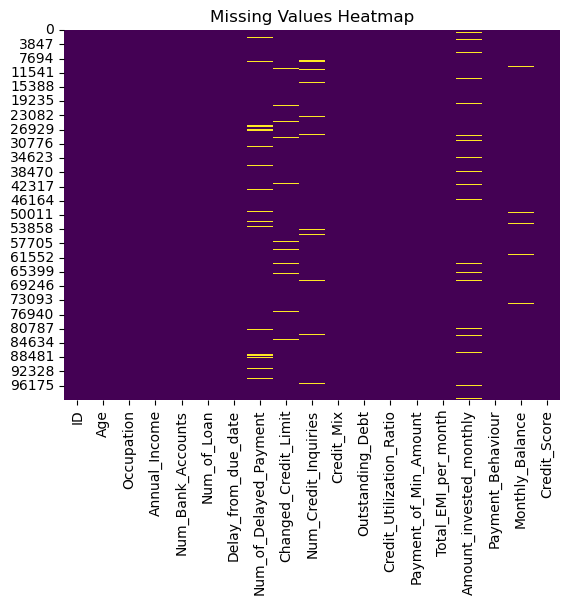

In [28]:
#import seaborn as sns
sns.heatmap(data_credit.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()# Mapa de calor para revisar valores faltantes

En el anterior mapa de calor podemos observar los ragos de los registros donde cada variable tiene valores Null

# 3. Ajuste de Variables Enteras - Análisis Univariado

### 3.1 Ajuste de Valores Nulos utilizando la media de los datos
Ya teniendo los datos en los formatos adecuados, procederemos al análisis de Valores Nulos y outliers de cada Variable

### 3.1.1 Análisis de la Variable *Num_of_Delayed_Payment*
Visualización de los Datos, de la variable de estudio sin ningún tipo de pre-procesamiento (Imputación de Nulos, y Outliers)

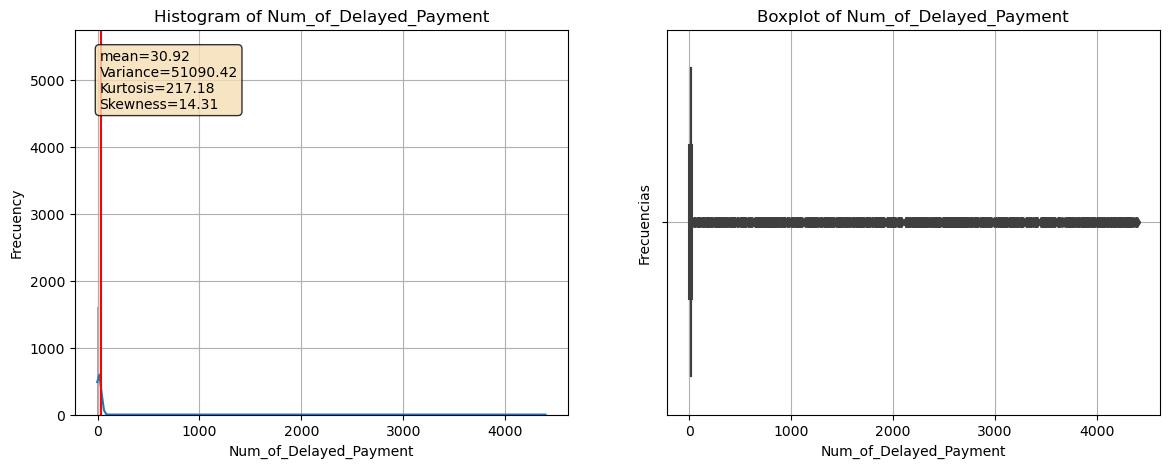

In [29]:
# Distribución (histograma) de la variable  Num_of_Delayed_Payment'
histogram_box(data_credit, 'Num_of_Delayed_Payment')

In [30]:
# Cantidad de personas con mas de 30,60 o 100 pagos atrasados - Revision de Outliers
# Usar una función lambda para contar los valores con más de 60 pagos atrasados
cantidad_mas_de_30_pagos_atrasados = data_credit['Num_of_Delayed_Payment'].apply(lambda x: x > 30).sum()
cantidad_mas_de_60_pagos_atrasados = data_credit['Num_of_Delayed_Payment'].apply(lambda x: x > 60).sum()
cantidad_mas_de_100_pagos_atrasados = data_credit['Num_of_Delayed_Payment'].apply(lambda x: x > 100).sum()
print('Cantidad de Registros con más pagos atrasados - OUTLIERS : \n\n','Más de 30: ', cantidad_mas_de_30_pagos_atrasados, 'Representarían el: ', np.round((cantidad_mas_de_30_pagos_atrasados/92998)*100,2), ' %', \
      '\n Más de 60: ', cantidad_mas_de_60_pagos_atrasados, 'Representarían el: ', np.round((cantidad_mas_de_60_pagos_atrasados/92998)*100,2), ' %', \
      '\n Más de 100: ',cantidad_mas_de_100_pagos_atrasados,'Representarían el: ', np.round((cantidad_mas_de_100_pagos_atrasados/92998)*100,2), ' %',)

Cantidad de Registros con más pagos atrasados - OUTLIERS : 

 Más de 30:  736 Representarían el:  0.79  % 
 Más de 60:  732 Representarían el:  0.79  % 
 Más de 100:  724 Representarían el:  0.78  %


#### Observaciones del Histograma:
Distribución: La mayor parte de los datos se concentra cerca del valor 0, con una rápida disminución en la frecuencia a medida que el número de pagos retrasados aumenta. Esto sugiere que la mayoría de las personas tienen pocos o ningún pago retrasado.<br><br>
<strong>Estadísticas Descriptivas:</strong><br>
<strong>Media (mean): </strong>30.92. En promedio, las personas tienen aproximadamente 31 pagos retrasados.<br>
<strong>Varianza (variance):</strong> 51090.42. Indica una gran dispersión en los datos, lo que significa que hay mucha variabilidad en el número de pagos retrasados.<br>
<strong>Curtosis (kurtosis):</strong>217.18. La curtosis es extremadamente alta, lo que sugiere que hay muchos valores atípicos (outliers) en los datos.<br>
<strong>Asimetría (skewness):</strong> 14.31. Una alta asimetría positiva indica que los datos están fuertemente sesgados hacia la derecha, con una cola larga hacia valores más altos.

### 3.1.1.1 Valores Nulos y Outliers - *Num_of_Delayed_Payment*
#### Imputados por la media de los datos (Sin tener en cuenta los datos con Outliers)
Se toma la decisión respecto a los outliers que se tienen del modelo, de usar la media de los datos. Se aplicará únicamente para aquellos pagos atrasados Mayores a 100. <strong>(Corresponde a un 0.78% de los datos).</strong>

In [31]:
# Calcular la media de los valores menores a 100 en la columna 'Num_of_Delayed_Payment'
mean_below_100 = data_credit[data_credit['Num_of_Delayed_Payment'] < 100]['Num_of_Delayed_Payment'].mean()

# Usar una función lambda para reemplazar los valores >= 100 con la media calculada
data_credit['Num_of_Delayed_Payment'] = data_credit['Num_of_Delayed_Payment'].apply(lambda x: mean_below_100 if x >= 100 else x)

In [32]:
# Imputación con la media (Una vez se han tratatado los outliers)
data_credit['Num_of_Delayed_Payment'].fillna(data_credit['Num_of_Delayed_Payment'].mean(), inplace=True)

In [33]:
# Podemos examinar tanto valores null(nulos), como valores nan (not a numeric)
tot = len(data_credit)
nulos = (data_credit.isnull().sum())
nulidad_null = pd.DataFrame( {'Variable':nulos.index, 'Cantidad Valores Nulo': nulos.values, 'Porcentaje de Nulidad (%) ' :np.round( ((nulos.values/tot)*100),2) } )
nulidad_null

,Variable,Cantidad Valores Nulo,Porcentaje de Nulidad (%)
0,ID,0,0.00
1,Age,0,0.00
2,Occupation,0,0.00
3,Annual_Income,0,0.00
4,Num_Bank_Accounts,0,0.00
5,Num_of_Loan,0,0.00
6,Delay_from_due_date,0,0.00
7,Num_of_Delayed_Payment,0,0.00
8,Changed_Credit_Limit,2091,2.09
9,Num_Credit_Inquiries,1965,1.96


### 3.1.1.2 Nueva Visualización -*Num_of_Delayed_Payment*
Visualización de los Datos, de la variable de estudio hecha la Imputación de Nulos, y Outliers, por el valor de la media de los datos considerados correctos.


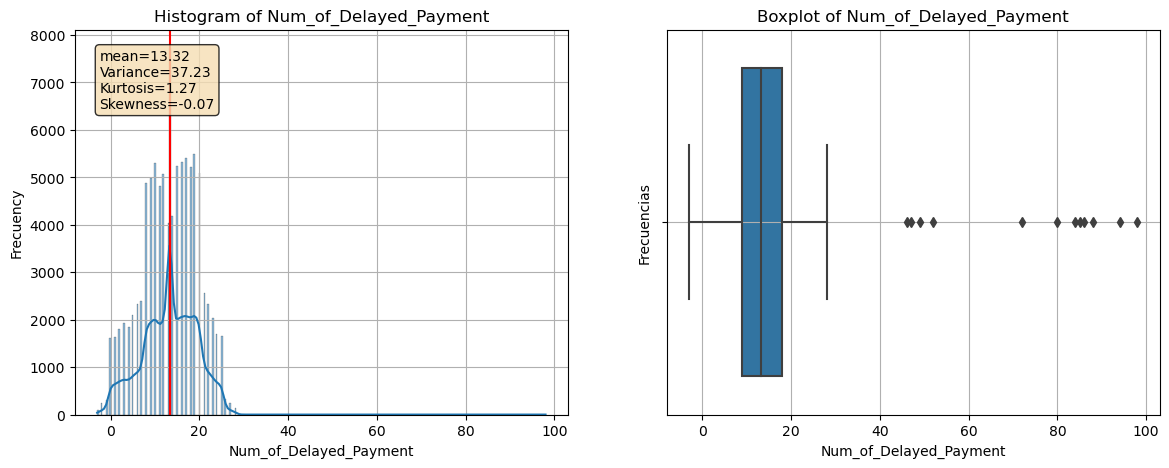

In [34]:
# Distribución (histograma) de la variable  Num_of_Delayed_Payment'
histogram_box(data_credit, 'Num_of_Delayed_Payment')

### Histograma de Num_of_Delayed_Payment (izquierda)

#### Distribución:

El histograma muestra la distribución de la variable Num_of_Delayed_Payment.
La mayoría de los valores se concentran alrededor de un rango bajo (entre 0 y 20).
La forma de la distribución es aproximadamente simétrica con un ligero sesgo negativo, lo que se confirma con el valor de la Skewness de -0.10.
Media, Varianza, Curtosis y Skewness:

Media (mean): 13.32. Indica el promedio de los pagos retrasados.<br>
Varianza (variance): 37.23. Indica la dispersión de los datos alrededor de la media.<br>
Curtosis (kurtosis): 1.27. Un valor positivo cercano a cero indica que la distribución tiene colas más pesadas que una distribución normal, pero no de manera extrema.<br>
Skewness: -0.07. Un valor cercano a cero indica que la distribución es aproximadamente simétrica, con un ligero sesgo hacia la izquierda (valores más pequeños).<br>

#### Outliers:

Aunque no se mencionan explícitamente en el histograma, los valores más allá del rango principal (mayores a 20) pueden ser considerados outliers.

### Boxplot de Num_of_Delayed_Payment (derecha)
Caja y Bigotes:

La caja representa el rango intercuartílico (IQR), es decir, el rango entre el primer cuartil (Q1) y el tercer cuartil (Q3). Esto cubre el 50% medio de los datos.
Los bigotes se extienden hasta 1.5 veces el IQR desde Q1 y Q3.
Mediana:

La línea dentro de la caja indica la mediana de los datos, que parece estar alrededor de los 10 pagos retrasados.
Outliers:

Los puntos fuera de los bigotes son considerados outliers.
Se observa que hay varios outliers dispersos entre los 30 y 100 pagos retrasados.
Estos outliers son aquellos valores que se encuentran más allá de 1.5 veces el IQR desde los cuartiles.

### Conclusión General
Valores Centrales:

La mayoría de los valores de Num_of_Delayed_Payment están concentrados en el rango de 0 a 20, con una media alrededor de 13.37.
Dispersión y Varianza:

La varianza relativamente baja (37.23) indica que los datos no están muy dispersos alrededor de la media.
Outliers:

Existen varios outliers identificables en el boxplot, que se extienden hasta el valor de 100.
Estos outliers deben ser considerados cuidadosamente ya que pueden influir en el análisis y en los modelos predictivos. La estrategia que mencionaste anteriormente para tratar estos valores es adecuada.
Distribución:

La distribución es ligeramente sesgada hacia la izquierda con colas más pesadas, pero en general se mantiene relativamente simétrica.

### 3.1.2 Análisis de la Variable *Changed_Credit_Limit*
Visualización de los Datos, de la variable de estudio sin ningún tipo de pre-procesamiento (Imputación de Nulos, y Outliers)

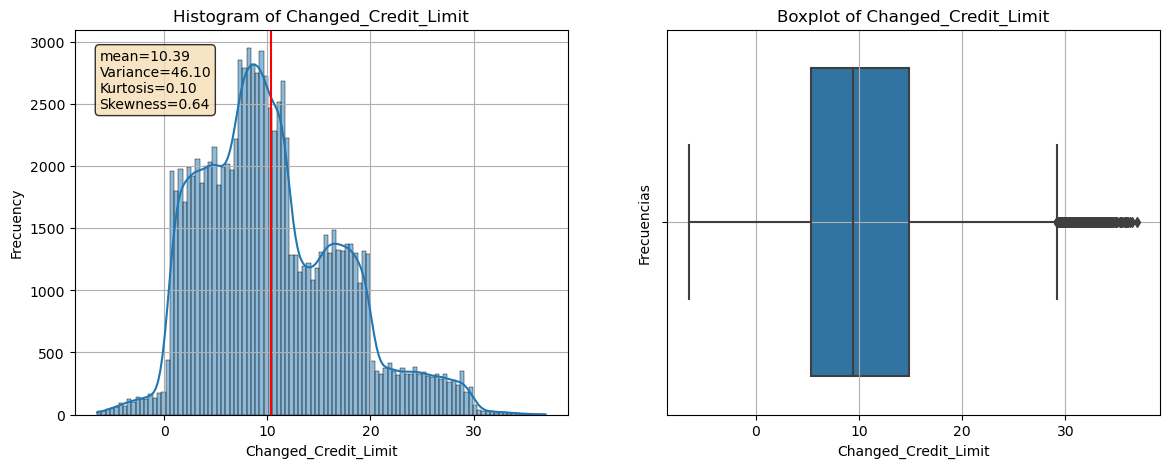

In [35]:
# Distribución (histograma) de la variable:  Changed_Credit_Limit'
histogram_box(data_credit, 'Changed_Credit_Limit')

# Hacer el análisis Inicial - Maria o algun compañero

### 3.1.2.1 DESCRIPCION DEL ANALISIS ANTES DE LA IMPUTACION

### 3.1.2.1 Imputación de valores Outliers y Null

In [36]:
vlr_changed_credit_limit_mayor_a_20 = data_credit['Changed_Credit_Limit'].apply(lambda x: x >20).sum()
print(vlr_changed_credit_limit_mayor_a_20)

8020


In [37]:
# Calcular la media de los valores menores a 20 en la columna 'Changed_Credit_Limit'
mean_below_20 = data_credit[data_credit['Changed_Credit_Limit'] < 20]['Changed_Credit_Limit'].mean()

# Usar una función lambda para reemplazar los valores >= 100 con la media calculada
data_credit['Changed_Credit_Limit'] = data_credit['Changed_Credit_Limit'].apply(lambda x: mean_below_20 if x >= 20 else x)

In [38]:
# Imputación con la media (Una vez se han tratatado los outliers)
data_credit['Changed_Credit_Limit'].fillna(data_credit['Changed_Credit_Limit'].mean(), inplace=True)

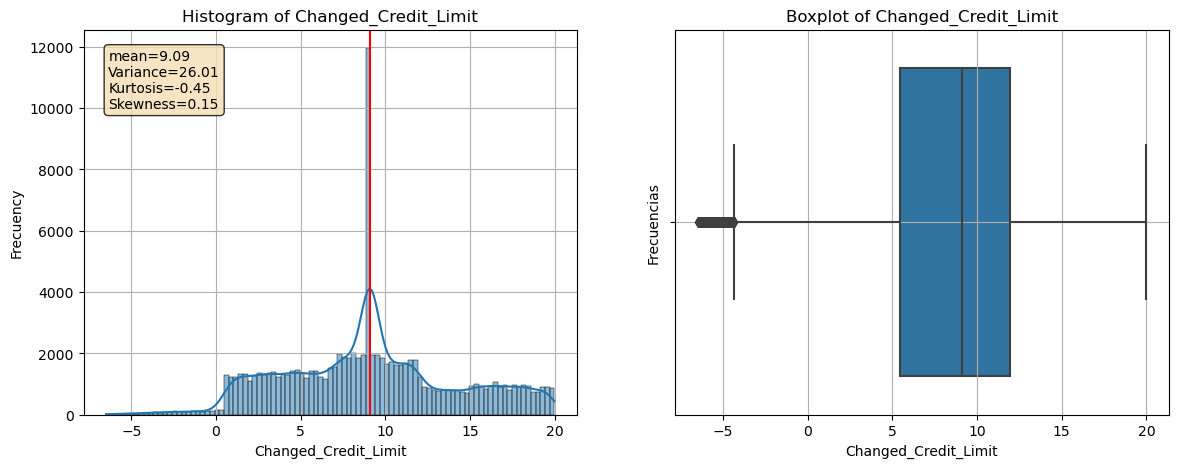

In [39]:
# Distribución (histograma) de la variable:  Changed_Credit_Limit'
histogram_box(data_credit, 'Changed_Credit_Limit')

### 3.1.2.2 ------------------------------------------------------      DESCRIPCION DEL ANALISIS DESPUES DE LA IMPUTACION

### 3.1.3 Análisis de la Variable *Num_Credit_Inquiries*
Visualización de los Datos, de la variable de estudio sin ningún tipo de pre-procesamiento (Imputación de Nulos, y Outliers)

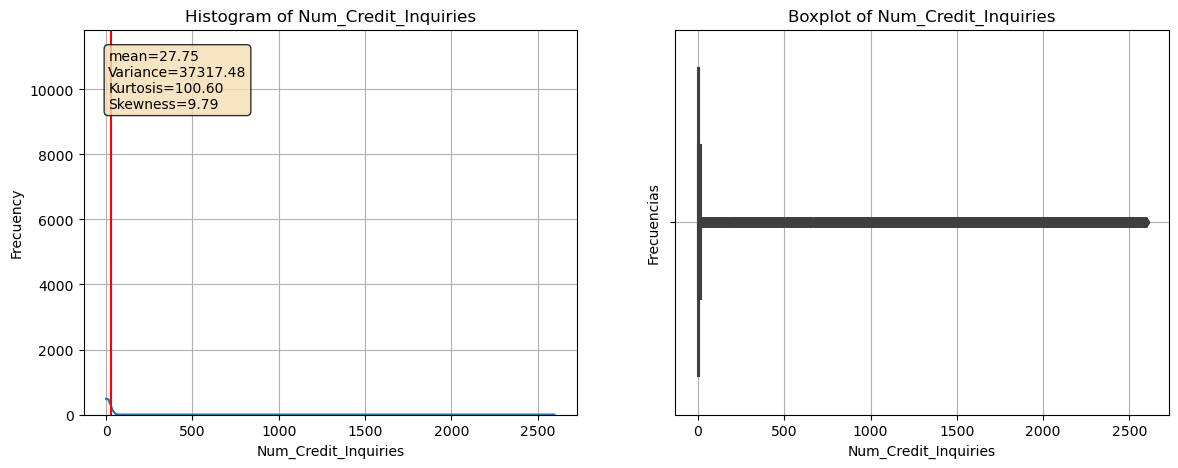

In [40]:
# Distribución (histograma) de la variable:  Num_Credit_Inquiries'
histogram_box(data_credit, 'Num_Credit_Inquiries')

## 3.1.3.1 Describir Antes de la Imputacion

DESCRIPCION ANTEES de la imputacion

In [41]:
vlr_Num_Credit_Inquiries_menores_a_20 = data_credit['Num_Credit_Inquiries'].apply(lambda x: x <20).sum()
print('El valor de Consultas de Crédito menores a 20 Consultas es de: ', vlr_Num_Credit_Inquiries_menores_a_20, 'Equivalen al: ' , (vlr_Num_Credit_Inquiries_menores_a_20/98035)*100, ' %' )

El valor de Consultas de Crédito menores a 20 Consultas es de:  96385 Equivalen al:  98.31692762788799  %


En el punto anterior como los valores de Numeros de Consultas de Crédito, en su gran mayoria *(98.3% de los Valores) Es menor a 20 Consultas*, Se tiene entonces que desde 20 Consultas en Adelante lo consideramos Outlier.


In [42]:
# Calcular la media de los valores menores a 20 en la columna 'Num_Credit_Inquiries'
mean_below_20 = data_credit[data_credit['Num_Credit_Inquiries'] < 20]['Num_Credit_Inquiries'].mean()

# Usar una función lambda para reemplazar los valores >= 100 con la media calculada
data_credit['Num_Credit_Inquiries'] = data_credit['Num_Credit_Inquiries'].apply(lambda x: mean_below_20 if x >= 20 else x)

In [43]:
# Imputación con la media (Una vez se han tratatado los outliers)
data_credit['Num_Credit_Inquiries'].fillna(data_credit['Num_Credit_Inquiries'].mean(), inplace=True)

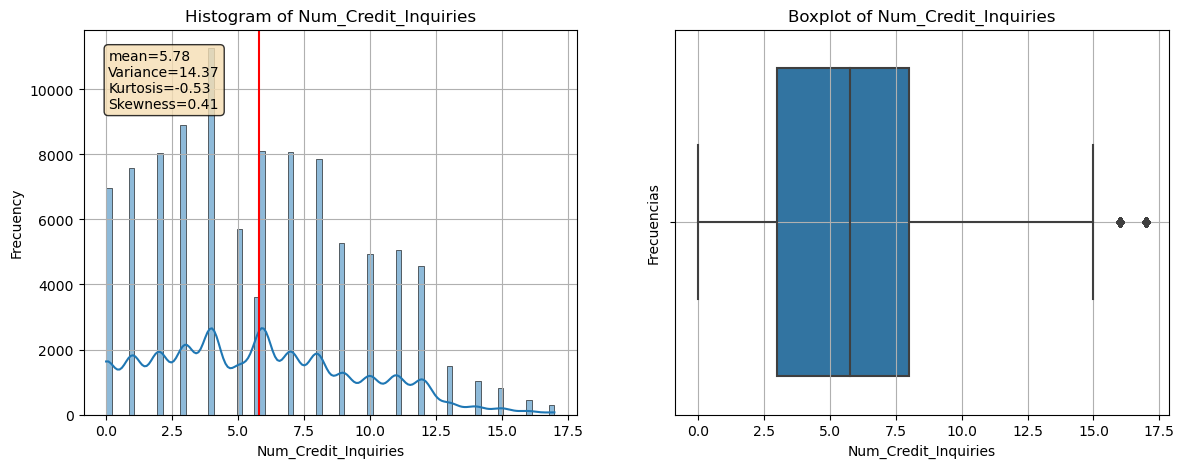

In [44]:
# Distribución (histograma) de la variable:  Num_Credit_Inquiries'
histogram_box(data_credit, 'Num_Credit_Inquiries')

## 3.1.3.2 Describir Despues de la imputacion

### 3.1.4  Análisis de la Variable *Amount_invested_monthly*
Visualización de los Datos, de la variable de estudio sin ningún tipo de pre-procesamiento (Imputación de Nulos, y Outliers)

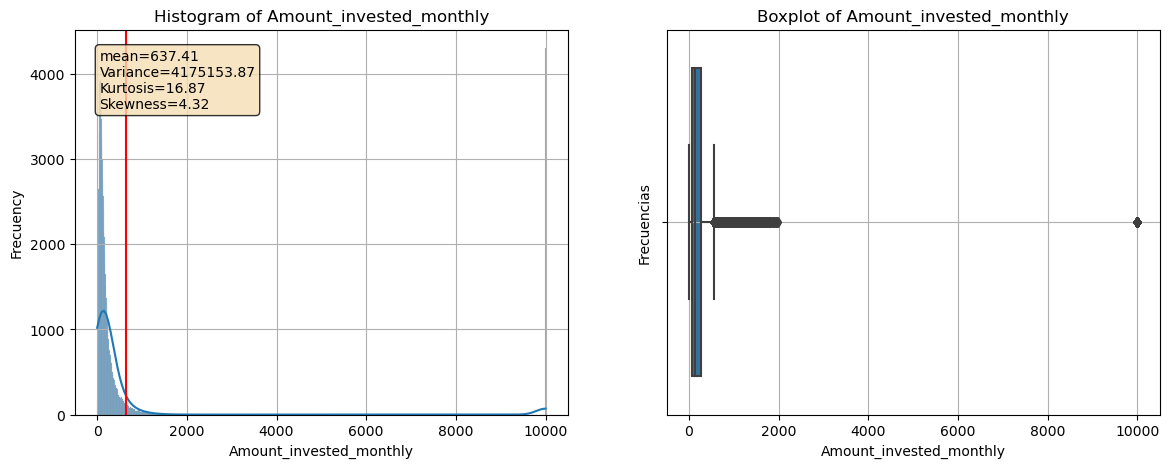

In [45]:
# Distribución (histograma) de la variable:  Amount_invested_monthly'
histogram_box(data_credit, 'Amount_invested_monthly')

In [46]:
vlr_Amount_invested_monthly_mayores_a_700 = data_credit['Amount_invested_monthly'].apply(lambda x: x >700).sum()

print('El valor de Inversión Mensual mayor a U$ 700 es: ', \
vlr_Amount_invested_monthly_mayores_a_700, ' Esto Equivale Sólo al: ' , np.round((vlr_Amount_invested_monthly_mayores_a_700/95521)*100,2), ' %' )

El valor de Inversión Mensual mayor a U$ 700 es:  7441  Esto Equivale Sólo al:  7.79  %


### Observación antes de Imputar
Teniendo en Cuenta Que la Media total de los datos es 637.41 dólares de Inversión Mensual, se puede inferir que el sesgamiento está determinado por los valores muy altos de Inversión Mensual, sin embargo son valores reales, pero no se pueden tener en cuenta para Imputar los valores Nulos porque habría error en el procedimiento.<br>
Por tal razón se imputarán los valores Nulos con la media de los valores de los registros que tienen hasta 700 Dólares.

### 3.1.4.1 Imputación de valores Null y Revisión de Outliers

In [47]:
# Calcular la media de los valores menores o iguales a U$ 700 en la columna 'Amount_invested_monthly'
mean_below_700 = data_credit[data_credit['Amount_invested_monthly'] <=700]['Amount_invested_monthly'].mean()
print("La Media Calculada con valores de inversión Mensual hasta U$ 700, es: \n\n ", mean_below_700, '\n')
# Imputación con la media (Una vez se han tratatado los outliers)
data_credit['Amount_invested_monthly'].fillna(mean_below_700, inplace=True)

La Media Calculada con valores de inversión Mensual hasta U$ 700, es: 

  169.27104605079228 



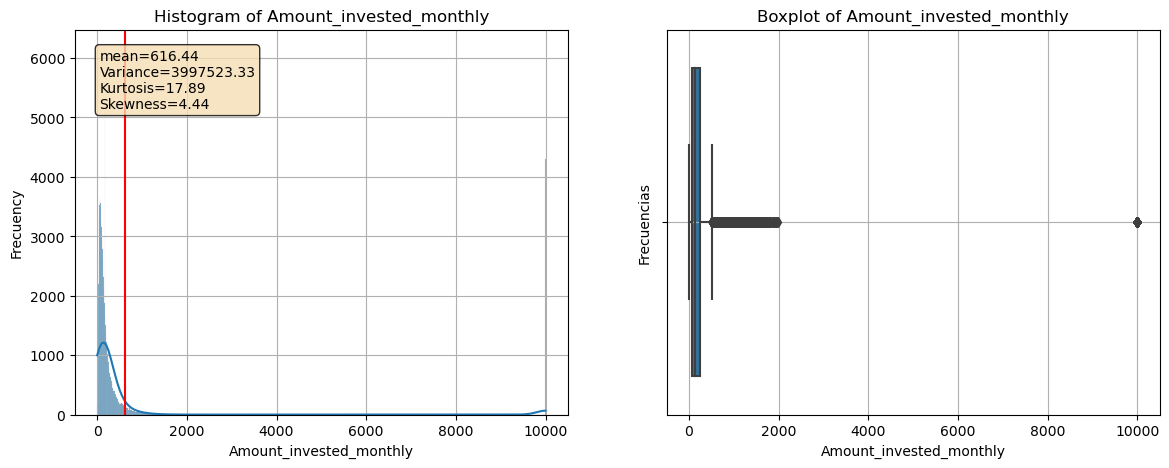

In [48]:
# Distribución (histograma) de la variable:  Amount_invested_monthly'
histogram_box(data_credit, 'Amount_invested_monthly')

# MARIA ----- OBSERVE LO SIGUIENTE:
## Si ud. ve que definitivamente esos valores mayores a 700 DE inversión Mensual no permiten una buena distribución de los datos, entonces aplique la media a esos datos, que se calculó antes de la imputación de los nulos.


In [49]:
# Usar una función lambda para reemplazar los valores U$ 700 con la media calculada antes de la imputación de los Nulos
data_credit['Amount_invested_monthly'] = data_credit['Amount_invested_monthly'].apply(lambda x: mean_below_700 if x >700 else x)

### 3.1.4.2 Visualización de los Datos Aplicando la media (Calculada antes de la Imputación de Nulls) a los valores Outliers superiores a 700 dolares

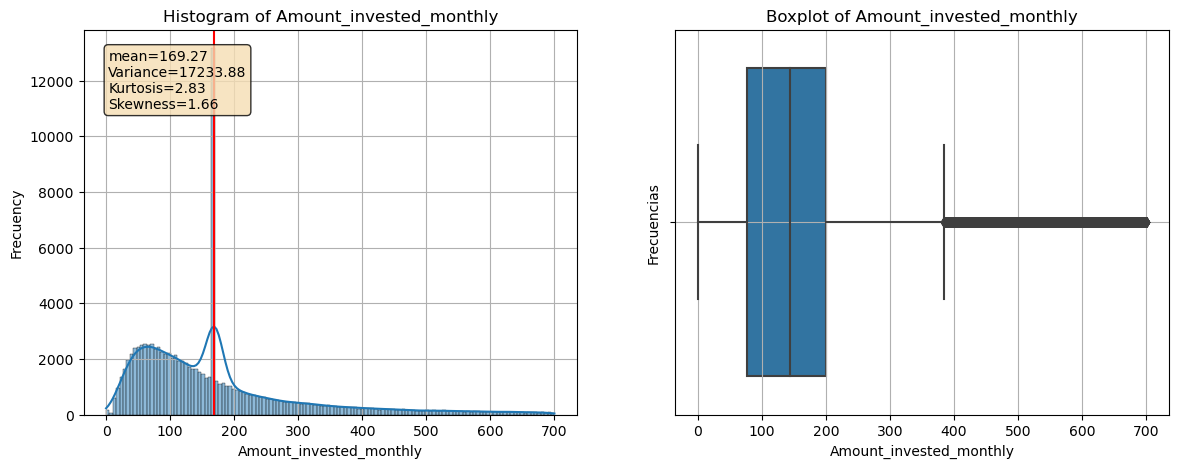

In [50]:
# Distribución (histograma) de la variable:  Amount_invested_monthly'
histogram_box(data_credit, 'Amount_invested_monthly')

## Se infiere .. que la mayor cantidad de personas tienen inversión mensual de menos de 200 dolares

In [51]:
vlr_Amount_invested_monthly_menores_a_200 = data_credit['Amount_invested_monthly'].apply(lambda x: x <200).sum()
print("Cantidad de Personas que Tienen inversion mensual Menor a U$ 200: ", vlr_Amount_invested_monthly_menores_a_200, \
      'Esto equivale a un: ', np.round((vlr_Amount_invested_monthly_menores_a_200/100000)*100,2), '%' )

Cantidad de Personas que Tienen inversion mensual Menor a U$ 200:  74969 Esto equivale a un:  74.97 %


### 3.1.5 Análisis de la Variable *Monthly_Balance*

Visualización de los Datos, de la variable de estudio sin ningún tipo de pre-procesamiento (Imputación de Nulos, y Outliers)

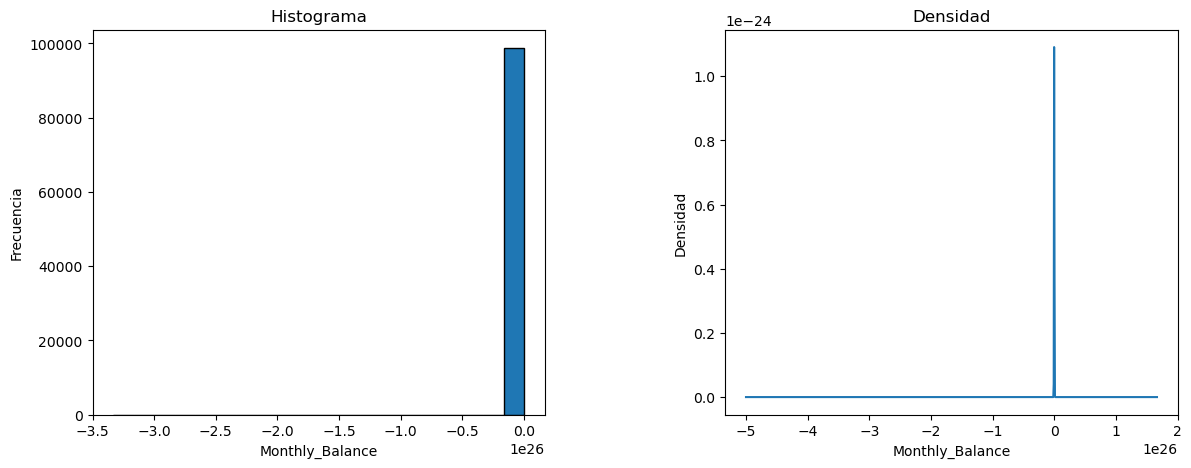

In [52]:
histogram_box_new(data_credit,'Monthly_Balance')  # Nuevo Histograma, solucionar problemas de tamaño de datos.

In [53]:
# Asegurarse de que la columna 'Valores' es de tipo float
data_credit['Monthly_Balance'] = data_credit['Monthly_Balance'].astype(float)

# Redondear los valores de la columna 'Valores' a dos cifras decimales
data_credit['Monthly_Balance'] = data_credit['Monthly_Balance'].round(2)

print(data_credit.head())

       ID  Age Occupation  Annual_Income  Num_Bank_Accounts  Num_of_Loan  \
0  0x1602   23  Scientist       19114.12                  3            4   
1  0x1603   23  Scientist       19114.12                  3            4   
2  0x1604 -500  Scientist       19114.12                  3            4   
3  0x1605   23  Scientist       19114.12                  3            4   
4  0x1606   23  Scientist       19114.12                  3            4   

   Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  \
0                    3                7.000000             11.270000   
1                   -1               13.322225             11.270000   
2                    3                7.000000              9.093669   
3                    5                4.000000              6.270000   
4                    6               13.322225             11.270000   

   Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  \
0                   4.0          _            809.98  

### continuando con el análisis de la Variable... tenemos los siguientes datos:

In [54]:
vlr_Monthly_Balance_menores_a_500 = data_credit['Monthly_Balance'].apply(lambda x: x <500).sum()
print("Cantidad de Personas que Tienen Balance Mensual menor a U$ 500: ", vlr_Monthly_Balance_menores_a_500, \
      'Esto equivale a un: ', np.round((vlr_Monthly_Balance_menores_a_500/98800)*100,2), '%' )

Cantidad de Personas que Tienen Balance Mensual menor a U$ 500:  77119 Esto equivale a un:  78.06 %


In [55]:
vlr_Monthly_Balance_Negativos = data_credit['Monthly_Balance'].apply(lambda x: x <0).sum()
print("Cantidad de Personas que Tienen Balance Mensual menores a 0 -Valores-Negativos - : ", vlr_Monthly_Balance_Negativos, \
      'Esto equivale a un: ', np.round((vlr_Monthly_Balance_Negativos/98800)*100,2), '%' )

Cantidad de Personas que Tienen Balance Mensual menores a 0 -Valores-Negativos - :  9 Esto equivale a un:  0.01 %


In [56]:
vlr_Monthly_Balance_entre_0_y_1000 = data_credit['Monthly_Balance'].apply(lambda x: x>0 and x<=1000).sum()
print("Cantidad de Personas que Tienen Balance Mensual Mayores que U$ 0 y U$ 1000 : ", vlr_Monthly_Balance_entre_0_y_1000, \
      'Esto equivale a un: ', np.round((vlr_Monthly_Balance_entre_0_y_1000/98800)*100,2), '%' )

Cantidad de Personas que Tienen Balance Mensual Mayores que U$ 0 y U$ 1000 :  96407 Esto equivale a un:  97.58 %


In [57]:
vlr_Monthly_Balance_mayores_1000 = data_credit['Monthly_Balance'].apply(lambda x: x> 1000).sum()
print("Cantidad de Personas que Tienen Balance Mensual Mayores U$ 1000 : ", vlr_Monthly_Balance_mayores_1000, \
      'Esto equivale a un: ', np.round((vlr_Monthly_Balance_mayores_1000/98800)*100,2), '%' )

Cantidad de Personas que Tienen Balance Mensual Mayores U$ 1000 :  2384 Esto equivale a un:  2.41 %


In [58]:
vlr_Monthly_Balance_entre_1000_y_1605 = data_credit['Monthly_Balance'].apply(lambda x: x>1000 and x<=1605).sum()
print("Cantidad de Personas que Tienen Balance Mensual Entre U$ 1000 y U$ 1605 : ", vlr_Monthly_Balance_entre_1000_y_1605, \
      'Esto equivale a un: ', np.round((vlr_Monthly_Balance_entre_1000_y_1605/98800)*100,2), '%' )

Cantidad de Personas que Tienen Balance Mensual Entre U$ 1000 y U$ 1605 :  2384 Esto equivale a un:  2.41 %


### 3.1.5.1 Imputación de valores Null y Revisión de Outliers

#### A tener en cuenta:<br>
*9 Registros con Balance Mensual  Negativo*: El Balance Mensual Negativo puede corresponder a cobros que no se pudieron generar completamente (Como cuando descuentan Cuota de Manejo y no hay saldo Disponible). <br><br>
El resto de valores corresponde a Números enteros Mayores que 0, y Menores a 1605 Dólares, por lo tanto el procedimiento de Imputación a los valores Nulos, será con la media de los valores entre 0 y 1000 Dólares *(esto es el 97.6% de los Datos).*


In [59]:
# Calcular la media de los valores menores o iguales a U$ 700 en la columna 'Monthly_Balance'
mean_between_0_and_1000 = data_credit[(data_credit['Monthly_Balance'] > 0) & (data_credit['Monthly_Balance'] < 1000)]['Monthly_Balance'].mean()
print("La Media Calculada con valores de inversión Mensual de entre 0 y hasta 1000, es: \n\n ", mean_between_0_and_1000, '\n')
# Imputación con la media (Una vez se han tratatado los outliers)
data_credit['Monthly_Balance'].fillna(mean_between_0_and_1000, inplace=True)

La Media Calculada con valores de inversión Mensual de entre 0 y hasta 1000, es: 

  384.2513256298816 



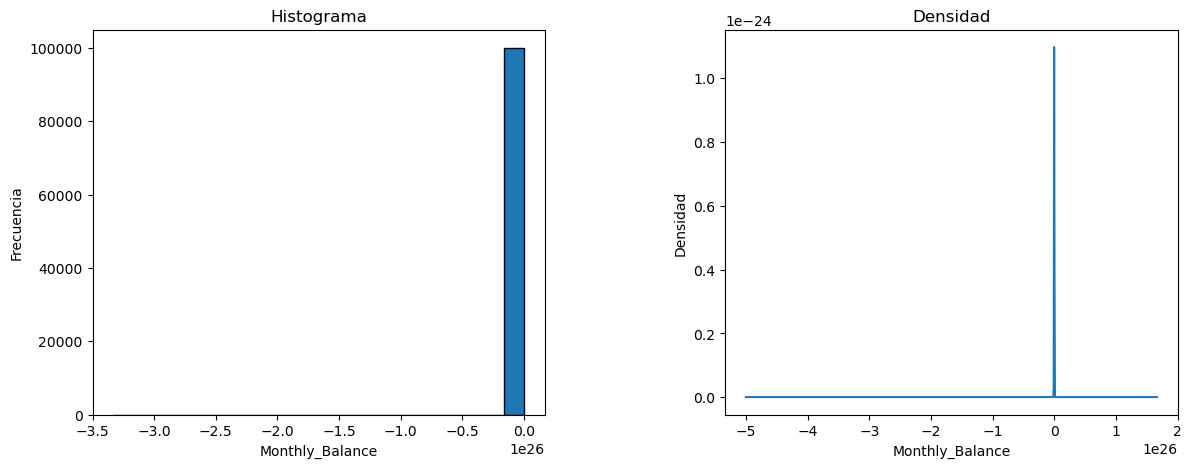

In [60]:
# Distribución (histograma) de la variable:  Amount_invested_monthly'
histogram_box_new(data_credit, 'Monthly_Balance')

### 3.1.6 Análisis de la Variable *Age*

# Distribución (histograma) de la variable: Age
histogram_box(data_credit,'Age')

En una primera Observación tenemos que Se consiguen valores de Edad que superan los 100 años, y otros con valores de Edad Negativos.<br>
Para Nuestro caso de Estudio se entenderá que se otorgará una tarjeta de crédito a personas que estén entre los 18 a los 90 Años. <br>
En Colombia, por Ejemplo hay Bancos que otorgan tarjeta de Crédito hasta los 70 Años de Edad.

### 3.1.6.1 Observación Relevante para Estudio de Outliers en la Variable Edad.
De acuerdo al primer análisis del Dataset, es relevante indicar que no hay edades <strong> entre 56 y 90 años</strong>, por lo tanto valores superiores a 90 se consideran inmediatamente con valores atípicos.

In [61]:
age56to90 = data_credit['Age'].apply(lambda x: float(x) if float(x) >56 and float(x) <90 else None).count()
print("Cantidad de Valores que tienen valores de Edad >56 Años y Edad <90 Años: ", age56to90, ' Correspondiente al: ', np.round((age56to90/100000)*100,2), ' %, del total de datos.' )

Cantidad de Valores que tienen valores de Edad >56 Años y Edad <90 Años:  0  Correspondiente al:  0.0  %, del total de datos.


In [62]:
age90 = data_credit['Age'].apply(lambda x: float(x) if float(x) >= 90 else None).count()
print("Cantidad de Valores que tienen valores de Edad >= 90 Años: ", age90, ' Correspondiente al: ', np.round((age90/100000)*100,2), ' %, del total de datos.' )

Cantidad de Valores que tienen valores de Edad >= 90 Años:  1895  Correspondiente al:  1.9  %, del total de datos.


In [63]:
age_card = data_credit['Age'].apply(lambda x: float(x) if float(x) >=18 and float(x) <90 else None).count()
print("Cantidad de Valores que tienen valores entre 18 y 90 Años: ", age_card, ' Correspondiente al: ', np.round((age_card/100000)*100,2), ' %, del total de datos.' )

Cantidad de Valores que tienen valores entre 18 y 90 Años:  91513  Correspondiente al:  91.51  %, del total de datos.


In [64]:
# Vamos a contar los valores que tienen Edad Negativa o de 0 años
age_negative = data_credit['Age'].apply(lambda x: float(x) if float(x) <=0 else None).count()
print("Cantidad de Valores que tienen valores de Edad < 1 Años: ", age_negative, ' Correspondiente al: ', np.round((age_negative/100000)*100,2), ' %, del total de datos.' )

Cantidad de Valores que tienen valores de Edad < 1 Años:  886  Correspondiente al:  0.89  %, del total de datos.


In [65]:
age0_18 = data_credit['Age'].apply(lambda x: float(x) if float(x) >0 and float(x) <18 else None).count()
print("Cantidad de Valores que tienen valores de Edad entre 0 y 18 Años: ", age0_18, ' Correspondiente al: ', np.round((age0_18/100000)*100,2), ' %, del total de datos.' )

Cantidad de Valores que tienen valores de Edad entre 0 y 18 Años:  5706  Correspondiente al:  5.71  %, del total de datos.


In [66]:
total_age = age_card+ age90 + age_negative + age0_18
print("Total de valores considerados Outliers en Edad : ", total_age , ' Correspondiente al: ', np.round((total_age /100000)*100),0, '%, del total de datos.' )

Total de valores considerados Outliers en Edad :  100000  Correspondiente al:  100.0 0 %, del total de datos.


### 3.1.6.2 Ajuste de los Valores Outliers - Análisis de la Variable *Age*

In [67]:
# Calcular la media de las edades, teniendo en cuenta que tanto valores negativos como valores por encima de 90 años son Outliers
mean_age = data_credit[(data_credit['Age'] > 18) & (data_credit['Age'] < 90)]['Age'].mean()
print("La Media Calculada con valores de Edad para tener tarjeta de crédito es: \n\n ", mean_age, '\n')
# Imputación con la media (Una vez se han tratatado los outliers)
data_credit['Age'] = data_credit['Age'].apply(lambda x: mean_age if x >90 else x)# Mayores a 90 Años
data_credit['Age'] = data_credit['Age'].apply(lambda x: mean_age if x <18 else x)# A valores Negativos y hasta 18 años.

La Media Calculada con valores de Edad para tener tarjeta de crédito es: 

  34.86596804595638 



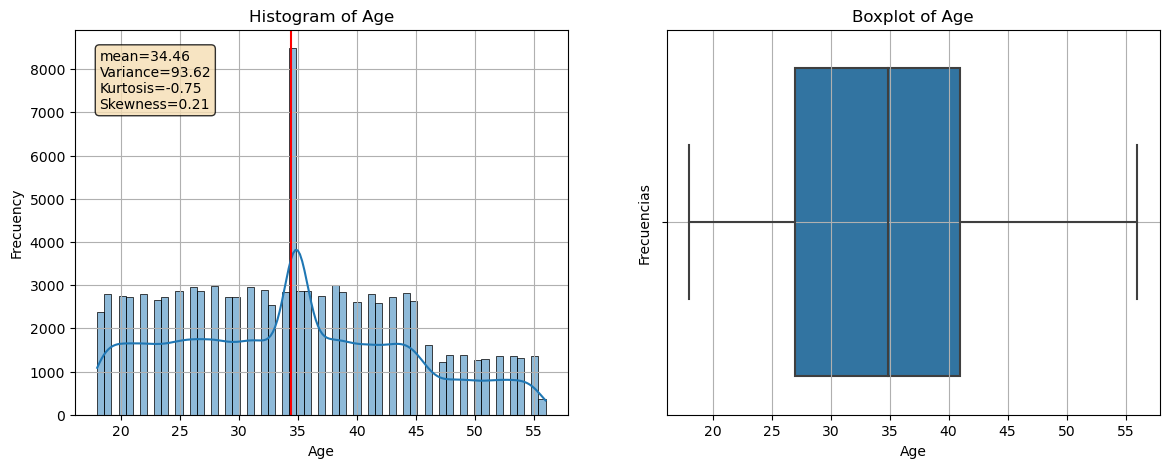

In [68]:
histogram_box(data_credit,'Age')

In [69]:
# Crear los bins (intervalos) y las etiquetas para los rangos de edad
bins = [18, 23, 28, 33, 38, 43, 48, 53, 56]
labels = ['18-22', '23-27', '28-32', '33-37', '38-42', '43-47', '48-52', '53-56']

# Crear una nueva columna en el DataFrame para los rangos de edad
data_credit['Rango_Edad'] = pd.cut(data_credit['Age'], bins=bins, labels=labels, right=False)

# Tabular la cantidad de registros por cada rango de edad
tabla_edades = data_credit['Rango_Edad'].value_counts().sort_index()

# Mostrar la tabla de rangos de edad
print(tabla_edades)

Rango_Edad
18-22    13423
23-27    14033
28-32    14269
33-37    22343
38-42    13811
43-47    11048
48-52     6680
53-56     4031
Name: count, dtype: int64


### Observación:
Como puede Observarse un ajuste adecuado de los datos incluso nos permite inferir que los valores iniciales por encima de laos 56 Años, seguramente eran datos equivocados.<br> Las edades entre 18 años y hasta 45 años son las que aparecen con mayor frecuencia, y con valores bastante elevados entre el rango de edades de 33 a 37 años.

# HACER OTROS ANALSIS ---

### 3.1.7 Análisis de la Variable *Annual_Income*
Visualización de los Datos, de la variable de estudio sin ningún tipo de pre-procesamiento (Imputación de Nulos, y Outliers)

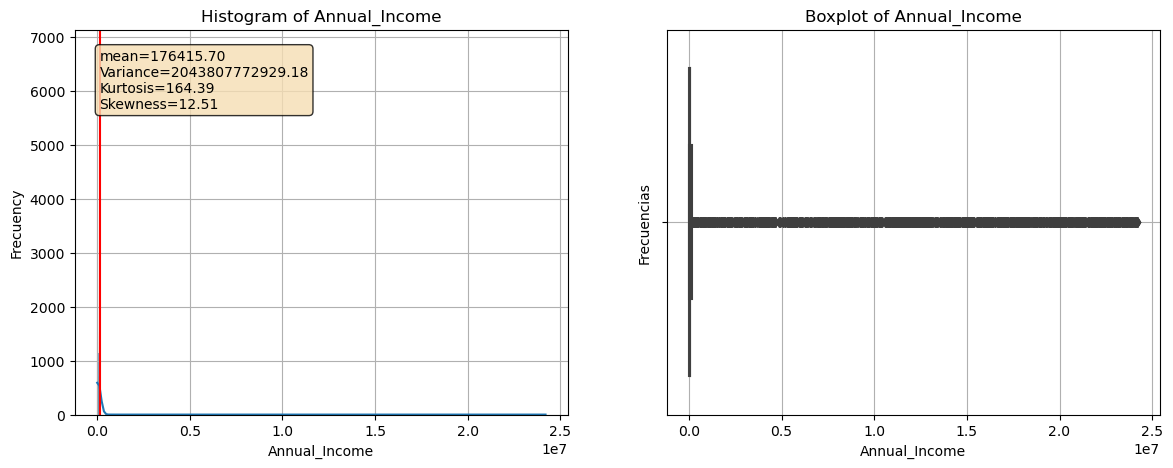

In [70]:
histogram_box(data_credit, 'Annual_Income')

### 3.1.7.1 Revision de Outliers - Variable - Annual_Income

In [84]:
# Annual_Income - Revision de Outliers
print("El Valor Máximo encontrado es: ", data_credit['Annual_Income'].max(), ' y el mínimo es: ', data_credit['Annual_Income'].min(), '\n')
vlr_negatives = data_credit['Annual_Income'].apply(lambda x: x < 0).sum()
vlr_50 = data_credit['Annual_Income'].apply(lambda x: x >=0 and x <= 50000).sum()
vlr_100 = data_credit['Annual_Income'].apply(lambda x: x > 50000 and x <= 100000).sum()
vlr_200 = data_credit['Annual_Income'].apply(lambda x: x > 100000 and x <= 200000).sum()
vlr_300 = data_credit['Annual_Income'].apply(lambda x: x > 200000 and x <= 300000).sum()
vlr_301 = data_credit['Annual_Income'].apply(lambda x: x > 300000).sum()

total=vlr_negatives+vlr_50+vlr_100+vlr_101
print("El total de Registros con datos en la variable Annual_Income: ", total_registros, '==', total )
print('Ingresos Negativos: ', vlr_negatives, 'Representarían el: ', np.round((vlr_negatives/100000)*100,2), ' %')
print('Entre 0 y U$ 50.000 : ', vlr_50, 'Representarían el: ', np.round((vlr_50/100000)*100,2), ' %')
print('Entre U$ 50.001 y U$ 100.000: ',vlr_100,'Representarían el: ', np.round((vlr_100/100000)*100,2), ' %')
print('Entre U$ 100001 y U$ 200.000: ',vlr_200,'Representarían el: ', np.round((vlr_200/100000)*100,2), ' %')
print('Entre U$ 200001 y U$ 300.000: ',vlr_300,'Representarían el: ', np.round((vlr_300/100000)*100,2), ' %')
print('Mayores a U$ 300.000: ',vlr_301,'Representarían el: ', np.round((vlr_301/100000)*100,2), ' %')


El Valor Máximo encontrado es:  24198062.0  y el mínimo es:  7005.93 

El total de Registros con datos en la variable Annual_Income:  100000 == 100000
Ingresos Negativos:  0 Representarían el:  0.0  %
Entre 0 y U$ 50.000 :  60178 Representarían el:  60.18  %
Entre U$ 50.001 y U$ 100.000:  26224 Representarían el:  26.22  %
Entre U$ 100001 y U$ 200.000:  12599 Representarían el:  12.6  %
Entre U$ 200001 y U$ 300.000:  6 Representarían el:  0.01  %
Mayores a U$ 300.000:  993 Representarían el:  0.99  %


In [87]:
# Crear los bins (intervalos) y las etiquetas para los rangos de edad
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 150000, 200000, 1000000, 5000000]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-150', '150-200', '200-1000', '1000-50000']

# Crear una nueva columna en el DataFrame para los rangos de ingresos anuales
data_credit['Rango_Ingreso_Anual'] = pd.cut(data_credit['Annual_Income'], bins=bins, labels=labels, right=False, include_lowest=True)

# Tabular la cantidad de registros por cada rango de ingresos anuales
tabla_Ingresos_Anuales = data_credit['Rango_Ingreso_Anual'].value_counts().sort_index()

# Mostrar la tabla de rangos de ingresos anuales
print(tabla_Ingresos_Anuales)

# Opcional: Mostrar estadísticas descriptivas para verificar los datos
print('\n',data_credit['Annual_Income'].describe())

Rango_Ingreso_Anual
0-10           5602
10-20         21037
20-30         11452
30-40         14594
40-50          7493
50-60          6089
60-70          6848
70-80          5579
80-90          4792
90-100         2916
100-150       10600
150-200        1999
200-1000         38
1000-50000      147
Name: count, dtype: int64

 count    1.000000e+05
mean     1.764157e+05
std      1.429618e+06
min      7.005930e+03
25%      1.945750e+04
50%      3.757861e+04
75%      7.279092e+04
max      2.419806e+07
Name: Annual_Income, dtype: float64


Con el Despliegue anterior de los Ingresos Anuales podemos entender que el 99% de los Datos está representado entre 7.000 y 200.000 dólares.<br> Se consiguen 993 Valores que Superan los 300.000 dólares y varios valores con Millones de Dólares. 